In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

Resnet is an CNN based architecture(Residual Net). recent state of the art architectures are built on resnet backbone.

The CNN variation with all the tweaks was good enough for the mnist dataset giving close to 100 percent accuracy. A harder problem will help understand resnet better. A subset of ImageNet dataset is taken. It is an image classification problem.

In [3]:
def get_data(url,presize,resize):
    path = untar_data(url)
    return DataBlock(blocks=(ImageBlock,CategoryBlock),get_items=get_image_files,
                     splitter = GrandparentSplitter(valid_name='val'),get_y=parent_label,
                     item_tfms=Resize(presize), batch_tfms=[*aug_transforms(min_scale=0.5,size=resize),
                                                           Normalize.from_stats(*imagenet_stats)],
                    ).dataloaders(path,bs=128)
                     


In [4]:
dls=get_data(URLs.IMAGENETTE_160,160,128)

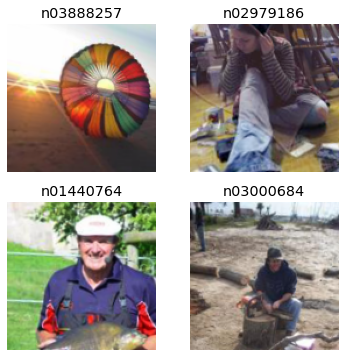

In [5]:
dls.show_batch(max_n=4)

Earlier , when the image size was 28x28 pixel, we convoluted the image through some layers to finally push it to [1X1] vector. So, a mini-batch we had a vector of 1X1 output neurons after convolutions with stride 2. In imagenette dataset, we have 128X128 and we are going to work on 224X224 later. the previous approach cannot be used because - too many stride 2 convolutions will have to be used, also, if we have a different dimensional input to the model, the model is to be modified again. So, will not work for inputs of different sizes.

The problem was solved by fully convolutional neural networks, where we would take average or max of all the elements in the convoltional filter called average/max pooling

This reduces the number of layers to take to reach 1X1 without compromising on the contributions of the convolutional filters.

In [6]:
def avg_pool(x) : return x.mean((2,3))

We keep putting more and more layers and finally let us say we have 256 filters , take average ppooling of each filter and form a 256,1 vector and feed it to linear layerwhich maps to c classes, this way the convolutional net is adapted to the problem with minimum memory constraints.

In [7]:
def block(ni,nf) : return ConvLayer(ni,nf,stride=2)
# this block will be replaced by another better one.making use of conv layer built-in
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

The fully convolutional layer is useful for problems where images of different sizes and orientation like natural photos - does not make sense for OCR because it is of constant size and slicing them up and averaging it to check if it looks like 3 or other digit does not make sense.

In [8]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(valley=0.0004786300996784121)

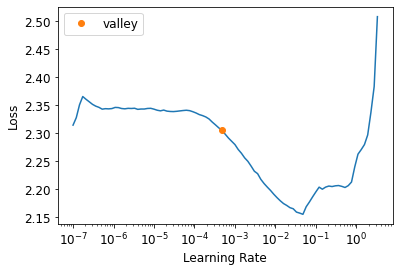

In [9]:

learn.lr_find()

3X10-3 is often a good learning rate for image based networks like CNN

In [10]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.874557,1.928221,0.359490,00:31
1,1.533785,1.701687,0.462930,00:46
2,1.292714,1.277565,0.583949,00:46
3,1.137749,1.092172,0.652739,00:46
4,1.040818,1.057869,0.667261,00:46


Stacking more layers to make it deep may seem like improving accuracy on the dataset,but it generally doesnot increase performance. With more layers, the network doesnot improve ,in fact sometimes degrades. 
so the idea of skip connections was introduced in resnets.

in resnets, instead of adding 36 layers to the end, there were layers which were interspersed between propre layers with connections skipped - they were just doing identity mapping but with trainable parameters as SGD failed when linear layers were added in the beginning.


x + conv2(conv1(x)) -> with gamma=0 in the additional layers added such that they act as linear layers.
T

In [11]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))
        
    def forward(self, x): return x + self.convs(x)

This cannot handle stride of size 2 and ni should be equal to nf. why? because to add convs(x) to x, convs(x) should output values similar in dimension to x.

This is handled by having convolutions of kernel size 1X1 for these skip connections . This way, the dimension is maintained. Also, this means that convolutions are done for all the pixels.

In [12]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [13]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))
     

try with resblock

In [14]:
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [15]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.944235,1.829984,0.370955,00:47
1,1.679545,1.582384,0.472611,00:47
2,1.403317,1.261728,0.583949,00:47
3,1.174128,1.080254,0.656560,00:48
4,1.037412,1.014913,0.686369,00:47
